# Generating tables and plots for the paper

The code in this notebook generates Tables 4 and 5, Figures 5 and 6 in our paper on [Provenance Graph Kernel](https://arxiv.org/abs/2010.10343). It is run automatically as part of the evaluation pipeline (`make plots`).

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

sns.set_style("whitegrid")
sns.set_context("paper")

In [2]:
from scripts.experiments.common import method_short_names

## Loading scoring and timing data

In [3]:
OUTPUTS_PATH = Path("outputs/")

In [4]:
def load_scoring(dataset_id) -> pd.DataFrame:
    outputs_folder = OUTPUTS_PATH / dataset_id
    output_filepath = outputs_folder / "scoring.pickled"
    
    results = pd.read_pickle(output_filepath)
    
    return results

In [5]:
# Identifiers for the six datasets
dataset_ids = ["MIMIC-PXC7", "CM-Buildings", "CM-Routes", "CM-RouteSets", "PG-T", "PG-D"]
dataset_names = ["MIMIC", "CM-B", "CM-R", "CM-RS", "PG-T", "PG-D"]

In [6]:
selected_groups = ["PK-G", "PK-A", "GK-slow", "GK-fast", "PNA"]

In [7]:
# The following graph kernels are in the "slow" group
slow_GKs = {
    "GK-GSamp",
    "GK-NSPD",
    "GK-NH",
    "GK-SPath",
    "GK-WL-OA-1",
    "GK-WL-OA-2",
    "GK-WL-OA-3",
    "GK-WL-OA-4",
    "GK-WL-OA-5",
    "GK-OddSth",
}

group_prefixes = {
    "GK": "GK-fast",  # all other graph kernels are in the "fast" group
    "PNA": "PNA",  # Provenance Network Analytics method
    "FG": "PK-G",  # provenance kernels using generic PROV types
    "FA": "PK-A",  # provenance kernels using generic PROV types and application types
    "DG": "PK-GD",  # provenance kernels using generic PROV types with 2-length derivations
    "DA": "PK-AD",  # provenance kernels using generic PROV types and application types with 2-length derivations
    "TG": "PK-GT",  # kernels with WdfT transformations (generic PROV types)
    "TA": "PK-AT",  # kernels with WdfT transformations (generic PROV types + application types)
}

def name_group(method: str) -> str:
    if method in slow_GKs:
        return "GK-slow"
    try:
        prefix = method.split("-", 1)[0]
        return group_prefixes[prefix]
    except KeyError:
        return "AppData"

def best_performers(results: pd.DataFrame, scoring="accuracy"):
    # Give them a group name for plotting
    results = results.copy()
    # add a "group_name" column to the table
    results["group_name"] = results.method.map(name_group)

    best_methods = set()
    for group_name in ["PK-G", "PK-A", "PNA", "GK-slow", "GK-fast"]:
        group_scorings = results[results.group_name == group_name]
        if group_scorings.empty:
            continue
        best_methods.add(group_scorings.groupby("method")[scoring].mean().idxmax())

    # return a filtered table with only the best methods identified above
    return results[results.method.isin(best_methods)]


### Loading scoring of the best methods

In [8]:
scorings = pd.DataFrame()

for dataset_id, dataset_name in zip(dataset_ids, dataset_names):
    # load the scoring data for this classification task
    df = load_scoring(dataset_id)
    df["dataset"] = dataset_name
    # only keep the scoring data of the best-performing methods in this task
    scorings = scorings.append(
        best_performers(df),
        ignore_index=True
    )

## Comparing timings of the best methods in each classification task

In [9]:
summary = scorings.groupby(["dataset", "group_name", "method"]).mean()
summary

accuracy        f1    recall  precision  \
dataset group_name method                                                
CM-B    GK-fast    GK-HC-3     0.894007  0.894007  0.894007   0.894007   
        GK-slow    GK-NSPD     0.896931  0.896931  0.896931   0.896931   
        PK-A       FA-1        0.895321  0.895321  0.895321   0.895321   
        PK-G       FG-4        0.896856  0.896856  0.896856   0.896856   
        PNA        PNA-RF      0.891592  0.891592  0.891592   0.891592   
CM-R    GK-fast    GK-WL-5     0.981039  0.981039  0.981039   0.981039   
        GK-slow    GK-WL-OA-4  0.976218  0.976218  0.976218   0.976218   
        PK-A       FA-5        0.968230  0.968230  0.968230   0.968230   
        PK-G       FG-3        0.918689  0.918689  0.918689   0.918689   
        PNA        PNA-DTree   0.940084  0.940084  0.940084   0.940084   
CM-RS   GK-fast    GK-WL-3     0.947250  0.947250  0.947250   0.947250   
        GK-slow    GK-WL-OA-5  0.961265  0.961265  0.961265   0.961265   
        PK-A       FA-4        0.966824  0.966824  0.966824   0.966824   
        PK-G       FG-5        0.956298  0.956298  0.956298   0.956298   
        PNA        PNA-DTree   0.943494  0.943494  0.943494   0.943494   
MIMIC   GK-fast    GK-WL-2     0.796750  0.796750  0.796750   0.796750   
        GK-slow    GK-GSamp    0.805318  0.805318  0.805318   0.805318   
        PK-A       FA-0        0.782336  0.782336  0.782336   0.782336   
        PK-G       FG-5        0.759638  0.759638  0.759638   0.759638   
        PNA        PNA-SVM     0.748976  0.748976  0.748976   0.748976   
PG-D    GK-fast    GK-WL-5     0.758000  0.758000  0.758000   0.758000   
        GK-slow    GK-SPath    0.774917  0.774917  0.774917   0.774917   
        PK-A       FA-2        0.783667  0.783667  0.783667   0.783667   
        PK-G       FG-5        0.752917  0.752917  0.752917   0.752917   
        PNA        PNA-SVM     0.715750  0.715750  0.715750   0.715750   
PG-T    GK-fast    GK-WL-5     0.704333  0.704333  0.704333   0.704333   
        GK-slow    GK-OddSth   0.718333  0.718333  0.718333   0.718333   
        PK-A       FA-3        0.853667  0.853667  0.853667   0.853667   
        PK-G       FG-3        0.692833  0.692833  0.692833   0.692833   
        PNA        PNA-RF      0.690417  0.690417  0.690417   0.690417   

                                      time  
dataset group_name method                   
CM-B    GK-fast    GK-HC-3        0.501371  
        GK-slow    GK-NSPD        8.058039  
        PK-A       FA-1           0.533871  
        PK-G       FG-4           0.848262  
        PNA        PNA-RF        76.556552  
CM-R    GK-fast    GK-WL-5        1.731250  
        GK-slow    GK-WL-OA-4   128.397924  
        PK-A       FA-5           2.413470  
        PK-G       FG-3           1.973335  
        PNA        PNA-DTree    258.284913  
CM-RS   GK-fast    GK-WL-3        2.528499  
        GK-slow    GK-WL-OA-5   390.126561  
        PK-A       FA-4           4.412479  
        PK-G       FG-5           4.201805  
        PNA        PNA-DTree    488.891166  
MIMIC   GK-fast    GK-WL-2        5.330222  
        GK-slow    GK-GSamp    1249.951379  
        PK-A       FA-0           6.231455  
        PK-G       FG-5          16.323493  
        PNA        PNA-SVM     1661.301301  
PG-D    GK-fast    GK-WL-5        1.928723  
        GK-slow    GK-SPath      14.349237  
        PK-A       FA-2           3.188576  
        PK-G       FG-5           4.896603  
        PNA        PNA-SVM      617.359420  
PG-T    GK-fast    GK-WL-5        0.855531  
        GK-slow    GK-OddSth      6.442797  
        PK-A       FA-3           1.378727  
        PK-G       FG-3           1.177336  
        PNA        PNA-RF       155.844582

### Finding the time cost of the best PK method (between PK-G and PK-A)

In [10]:
best_pk_accuracy = dict()  # best accuracy between PK-G and PK-A for a classification task
best_pk_method = dict()  # achieved by which method
best_pk_time = dict()  # and its corresponding time cost

for row in summary.itertuples():
    dataset, group_name, method = row.Index

    if group_name in {"PK-G", "PK-A"}:
        to_be_updated = True
        try:
            if best_pk_accuracy[dataset] > row.accuracy:
                to_be_updated = False
        except KeyError:
            pass  # first time seeing this dataset, to reco

        if to_be_updated:
            best_pk_accuracy[dataset] = row.accuracy
            best_pk_method[dataset] = method
            best_pk_time[dataset] = row.time

### Calculating the relative time for all methods in each classification task

In [11]:
data = []

for row in summary.itertuples():
    dataset, group_name, method = row.Index
    relative_time = row.time / best_pk_time[dataset]
    data.append((dataset, group_name, method, row.accuracy, relative_time))

rel_time_df = pd.DataFrame(data, columns=["Dataset", "Group", "Method", "Accuracy", "Relative Time"])

### Table 4
Within each dataset, we report the time cost of the best-performing method (shown in parentheses) from each comparison group relative to the time taken by the best-performing PK method (whose time cost shown as 1.0).

In [12]:
rel_time_df["time_method"] = rel_time_df.apply(
    lambda row: "%.1f (%s)" % (row[4], method_short_names[row[2]]),
    axis=1
)

In [13]:
table4 = rel_time_df.pivot(index="Dataset", columns="Group", values="time_method").reindex(dataset_names)[
    ["PK-G", "PK-A", "GK-fast", "GK-slow", "PNA"]
]
table4

Group,PK-G,PK-A,GK-fast,GK-slow,PNA
Dataset,,,,,
MIMIC,2.6 (G5),1.0 (A0),0.9 (WL2),200.6 (GS),266.6 (SVM)
CM-B,1.0 (G4),0.6 (A1),0.6 (HC3),9.5 (NSPD),90.3 (RF)
CM-R,0.8 (G3),1.0 (A5),0.7 (WL5),53.2 (WLO4),107.0 (DT)
CM-RS,1.0 (G5),1.0 (A4),0.6 (WL3),88.4 (WLO5),110.8 (DT)
PG-T,0.9 (G3),1.0 (A3),0.6 (WL5),4.7 (ODD),113.0 (RF)
PG-D,1.5 (G5),1.0 (A2),0.6 (WL5),4.5 (SP),193.6 (SVM)


In [14]:
# Save table 4 for later
table4.to_csv("plots/table4.csv")
table4.to_html("plots/table4.html")

## Comparing the accuracy of the best PK method vs the best in the other comparison groups

In [15]:
def ranksums(df: pd.DataFrame, methods, scoring="accuracy", pvalue_significant=0.05):
    # returns None if the difference between the two methods is not statistically significant
    # according to the ranksums test; otherwise, returns the mean difference value.

    assert len(methods) == 2
    assert scoring in df.columns

    print("Wilcoxon rank-sum test:", scoring)
    print(f"> Comparing {methods[0]} vs {methods[1]}")

    p1 = df[df.method == methods[0]]
    p1.reset_index(inplace=True)
    p1_mean = p1[scoring].mean()

    p2 = df[df.method == methods[1]]
    p2.reset_index(inplace=True)
    p2_mean = p2[scoring].mean()

    mean_diff = p1_mean - p2_mean
    _, pvalue = stats.ranksums(p1[scoring], p2[scoring])
    if pvalue > pvalue_significant:
        print(f"> Insignificant (pvalue = {pvalue * 100:.1f}%)")
        return None
    else:
        print(f"> *Significant* (pvalue = {pvalue * 100:.1f}%)")
        print(f"> Mean difference: {mean_diff * 100:+.1f}%")
        return mean_diff

In [16]:
def mean_diff_value_display(mean_diff, min_diff=0.02):
    if mean_diff is None:
        return "="

    # mean_diff is not None
    if abs(mean_diff) >= min_diff:
        return f"{mean_diff * 100:.0f}%"
    else:
        return "="

### Table 5

Summary of the accuracy differences between the best-performing PK-based method and the best-performing method in the GK-slow, GK-fast, and PNA groups. An “=” sign means the accuracy difference is not statistically significant according to the Wilcoxson Rank Sum test (also known as Mann Whitney U Test); while a positive/negative value shows how much the PK-based method outperforms/under-performs the corresponding GK/PNA method, respectively, when the difference is statistically significant.

In [17]:
def rank_against(selected_groups, scoring="accuracy", min_diff=0.02):
    # Looking for the best method in the select groups for each dataset
    # calculate their mean scoring
    df = scorings[scorings.group_name.isin(selected_groups)].groupby(["dataset", "method"]).mean()
    # find the method with the highest mean scoring value for each dataset
    best_method = {
        dataset: group.set_index("method")[scoring].idxmax()
        for dataset, group in df.reset_index().groupby("dataset")
    }

    data = []
    for row in summary.itertuples():
        dataset, group_name, method = row.Index
        if method != best_method[dataset]:
            print(f"[ {dataset}: comparing {best_method[dataset]} against {method} ]")
            mean_diff = ranksums(scorings[scorings.dataset == dataset], [best_method[dataset], method])
            # ignoring difference less than min_diff
            cell_value = mean_diff_value_display(mean_diff, min_diff)
        else:
            cell_value = f"[{method_short_names.get(method, method)}]"
        data.append((dataset, group_name, method, cell_value))

    comp_df = pd.DataFrame(data, columns=["Dataset", "Group", "Method", "Diff"])
    return comp_df

In [18]:
comparison_df = rank_against({"PK-A", "PK-D"}, min_diff=0.02)

[ CM-B: comparing FA-1 against GK-HC-3 ]
Wilcoxon rank-sum test: accuracy
> Comparing FA-1 vs GK-HC-3
> Insignificant (pvalue = 64.7%)
[ CM-B: comparing FA-1 against GK-NSPD ]
Wilcoxon rank-sum test: accuracy
> Comparing FA-1 vs GK-NSPD
> Insignificant (pvalue = 56.5%)
[ CM-B: comparing FA-1 against FG-4 ]
Wilcoxon rank-sum test: accuracy
> Comparing FA-1 vs FG-4
> Insignificant (pvalue = 56.9%)
[ CM-B: comparing FA-1 against PNA-RF ]
Wilcoxon rank-sum test: accuracy
> Comparing FA-1 vs PNA-RF
> Insignificant (pvalue = 27.8%)
[ CM-R: comparing FA-5 against GK-WL-5 ]
Wilcoxon rank-sum test: accuracy
> Comparing FA-5 vs GK-WL-5
> *Significant* (pvalue = 0.0%)
> Mean difference: -1.3%
[ CM-R: comparing FA-5 against GK-WL-OA-4 ]
Wilcoxon rank-sum test: accuracy
> Comparing FA-5 vs GK-WL-OA-4
> *Significant* (pvalue = 0.0%)
> Mean difference: -0.8%
[ CM-R: comparing FA-5 against FG-3 ]
Wilcoxon rank-sum test: accuracy
> Comparing FA-5 vs FG-3
> *Significant* (pvalue = 0.0%)
> Mean differenc

In [19]:
table5 = comparison_df.pivot(index="Group", columns="Dataset", values="Diff").reindex(["GK-slow", "GK-fast", "PNA"])[dataset_names]
table5

Dataset,MIMIC,CM-B,CM-R,CM-RS,PG-T,PG-D
Group,,,,,,
GK-slow,-2%,=,=,=,14%,=
GK-fast,=,=,=,=,15%,3%
PNA,3%,=,3%,2%,16%,7%


In [20]:
# Save Table 5 for later
table5.to_csv("plots/table5.csv")
table5.to_html("plots/table5.html")

## Generating plots

In [21]:
# store the current colour palette
current_palette = sns.color_palette()

### Figure 5: The relative time costs of the best-performing methods reported in Table 4 plotted on the log scale

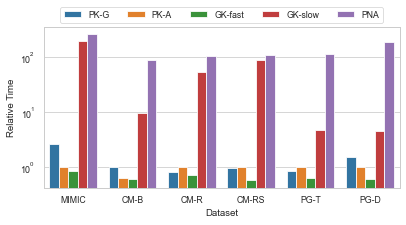

In [22]:
dataset_order = ["MIMIC", "CM-B", "CM-R", "CM-RS", "PG-T", "PG-D"]
selected_groups = ["PK-G", "PK-A", "GK-fast", "GK-slow", "PNA"]
plot = sns.barplot(x="Dataset", y="Relative Time", hue="Group", order=dataset_order, hue_order=selected_groups, data=rel_time_df)
plot.set_yscale("log")
plt.legend(loc='upper center', ncol=5, bbox_to_anchor=(0.5, 1.15))
plot.figure.set_size_inches(5.75, 3.25)
plt.tight_layout()

In [23]:
# saving the above plot
plot.figure.savefig("plots/best-performers-relative-timing.pdf")

### Figure 6: The mean classification accuracy of the best-performing provenance kernels, generic graph kernels, and PNA methods across the six classification tasks. The error bars show the 95-percent confidence intervals

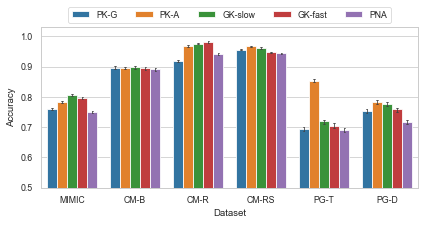

In [24]:
plt.figure()
selected_groups = ["PK-G", "PK-A", "GK-slow", "GK-fast", "PNA"]
df = scorings[scorings.group_name.isin(set(selected_groups))]
plot = sns.barplot(x="dataset", y="accuracy", hue="group_name",
                   hue_order=selected_groups, data=df, palette=current_palette,
                   errwidth=0.8, capsize=0.02)
plot.set(xlabel="Dataset", ylabel="Accuracy")
plot.figure.set_size_inches(6, 3.25)
plt.legend(loc='upper center', ncol=5, bbox_to_anchor=(0.5, 1.15))
plt.ylim(0.5)
plt.tight_layout()

In [25]:
plot.figure.savefig("plots/accuracy-best-performers.pdf")